### Train Logistic Regression

- Joel Stremmel
- 04-17-23

##### About

Train Logistic Regression on the formatted data using K-Fold Cross-Validation and save the scores.

##### Imports

In [1]:
import os
import re
import glob
import pickle
import requests
import zipfile
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nlpaug.augmenter.word import WordEmbsAug
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

2023-04-19 21:45:43.364880: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 21:45:43.417873: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 21:45:43.418749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 21:45:44.080690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### Set Parameters

In [2]:
ngram_range = (2, 4)
min_df = 5
max_df = 0.9
sublinear_tf = True
C = 0.1
seed = 42
max_iter = 5000
penalty = "l2"
solver = 'saga'
model_key = 'lr_aug'
results_dir = './results'
input_dir = './data'

sep2newlines = True
sep_token = "</s>"
double_newlines = "\n\n"

add_synthetic = True
aug_p = 0.3

glove_file = 'data/glove.6B.50d.txt'
glove_zip = 'data/glove.6B.zip'
glove_url = 'http://nlp.stanford.edu/data/glove.6B.zip'

##### Load Formatted Data

In [3]:
with open(os.path.join(input_dir, 'X_folds.pkl'), 'rb') as f:
    X_folds = pickle.load(f)

with open(os.path.join(input_dir, 'y_folds.pkl'), 'rb') as f:
    y_folds = pickle.load(f)

##### Define a Download Function

In [4]:
def download_file(url, filename):
    
    with open(filename, 'wb') as file:
        response = requests.get(url)
        file.write(response.content)

##### Download GloVe Embeddings if Non-Existent

In [5]:
if not os.path.isfile(glove_file):
    
    print('Downloading glove embeddings file...')
    os.makedirs(input_dir, exist_ok=True)
    
    download_file(url, glove_zip)
    
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extractall(input_dir)
        
    os.remove(glove_zip)
    print('Finished downloading glove embeddings file.')

##### Check Data Shape

In [6]:
assert len(X_folds) == len(y_folds), "Expected the same number of folds in X and y."
X = list(X_folds.values())
y = list(y_folds.values())

In [7]:
len(X), len(y)

(5, 5)

In [8]:
for x_fold, y_fold in zip(X, y):
    for x_sample, target in zip(x_fold, y_fold):
        if x_sample == '':
            print(x_sample, target)

 1
 0
 1
 0
 0
 1
 1
 1
 1
 1
 1
 1
 0


##### Check Target Prevalence

In [9]:
print(f"Target prevalance: {np.mean(np.concatenate(y))}.")

Target prevalance: 0.5277777777777778.


##### Vectorize Text and Fit Model to Each Fold

In [10]:
y_probs, y_trues = [], []
for i in range(len(X)):
    
    print(f"Fitting model using fold {i} as out of fold data.")
    
    # Define TFIDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        sublinear_tf=sublinear_tf,
        strip_accents="unicode",
        analyzer="word",
        token_pattern=r"(?u)\b\w\w+\b",
        stop_words="english",
        ngram_range=ngram_range,
        norm="l2",
        min_df=min_df,
        max_df=max_df,
        smooth_idf=False,
        lowercase=True
    )

    # Identify train folds and shuffle samples
    X_train, y_train = np.concatenate(X[0:i] + X[i+1:], axis=0), np.concatenate(y[0:i] + y[i+1:], axis=0)
    indices = np.arange(len(y_train))
    np.random.shuffle(indices)
    X_train, y_train = X_train[indices], y_train[indices]
    
    # Identify test folds
    X_test, y_test = X[i], y[i]

    # Optionally replace sep token with double newlines
    if sep2newlines:
        X_train = np.array([sample.replace(sep_token, double_newlines) for sample in X_train])
        X_test = np.array([sample.replace(sep_token, double_newlines) for sample in X_test])

    # Vectorize text
    train_features = tfidf_vectorizer.fit_transform(X_train)
    test_features = tfidf_vectorizer.transform(X_test)
    
    # Optionally add synthetic samples
    if add_synthetic:
        
        # Augment train data with synthetic text using WordEmbsAug
        # .ContextualWordEmbsAug(model_path="roberta-large", action="insert")
        aug = WordEmbsAug(model_type='glove', model_path=glove_file, action='insert', aug_p=aug_p)
        
        # Only augment non-empty samples
        # In general, we should check for empty samples and possibly remove them
        X_train_aug = []
        y_train_aug = []
        for sample, target in zip(X_train, y_train):
            if sample != '':
                aug_sample = aug.augment(sample)[0]
                X_train_aug.append(aug_sample)
                y_train_aug.append(target)
        
        # Vectorize synthetic text
        train_features_aug = tfidf_vectorizer.transform(np.array(X_train_aug))
        
        # Combine original and synthetic text
        train_features = sp.sparse.vstack([train_features, train_features_aug])
        y_train = np.concatenate((y_train, y_train_aug), axis=0)
        
        # Shuffle combined training data
        new_indices = np.arange(len(y_train))
        np.random.shuffle(new_indices)
        train_features, y_train = train_features[new_indices], y_train[new_indices]
    
    # Define and fit model
    lr = LogisticRegression(
        solver=solver,
        fit_intercept=True,
        max_iter=max_iter,
        penalty=penalty,
        C=C,
        class_weight=None,
        random_state=seed
    )
    lr.fit(train_features, y_train)
    
    # Predict on test folds and save labels and scores
    y_prob = lr.predict_proba(test_features)[:, 1]
    y_probs.append(y_prob)
    y_trues.append(y_test)

Fitting model using fold 0 as out of fold data.
102
102 102
Fitting model using fold 1 as out of fold data.
103
103 103
Fitting model using fold 2 as out of fold data.
104
104 104
Fitting model using fold 3 as out of fold data.
110
110 110
Fitting model using fold 4 as out of fold data.
105
105 105


##### Save Model Probabilities on Test Folds and True Labels

In [11]:
with open(os.path.join(results_dir, f'{model_key}_y_trues.pkl'), 'wb') as f:
    pickle.dump(y_trues, f)

with open(os.path.join(results_dir, f'{model_key}_y_probs.pkl'), 'wb') as f:
    pickle.dump(y_probs, f)

##### Fit a Model to All of the Data

In [12]:
X_train, y_train = np.concatenate(X, axis=0), np.concatenate(y, axis=0)
indices = np.arange(len(y_train))
np.random.shuffle(indices)
X_train, y_train = X_train[indices], y_train[indices]

tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=sublinear_tf,
    strip_accents="unicode",
    analyzer="word",
    token_pattern=r"(?u)\b\w\w+\b",
    stop_words="english",
    ngram_range=ngram_range,
    norm="l2",
    min_df=min_df,
    max_df=max_df,
    smooth_idf=False,
    lowercase=True
)

train_features = tfidf_vectorizer.fit_transform(X_train)

lr = LogisticRegression(
    solver=solver,
    fit_intercept=True,
    max_iter=max_iter,
    penalty=penalty,
    class_weight=None,
    random_state=seed
)

lr = lr.fit(train_features, y_train)

##### Define a Function to Plot the LR Model Coefficients

In [13]:
def plot_coefs(clf, features, top_n=10, x_size=12, y_size=12):
    """
    Plot top N coefficients by absolute value in descending order
    """

    features_and_intercept = np.concatenate((features, ['intercept']), axis=0)
    coefficients = np.concatenate((clf.coef_[0], clf.intercept_), axis=0)

    indices = (-np.abs(coefficients)).argsort()
    top_coefs = coefficients[indices][0: top_n].tolist()
    top_feats = features_and_intercept[indices][0: top_n].tolist()
    
    top_coefs.reverse()
    top_feats.reverse()

    plt.clf()
    plt.figure(figsize=(x_size, y_size))

    plt.title('Logistic Regression Coefficients')
    plt.barh(range(len(top_coefs)), top_coefs, color='navy', align='center')
    plt.yticks(range(len(top_coefs)), top_feats)
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.axvline(x=0, color='red', linestyle='--')

    plt.show()

##### Plot Coefficients

<Figure size 640x480 with 0 Axes>

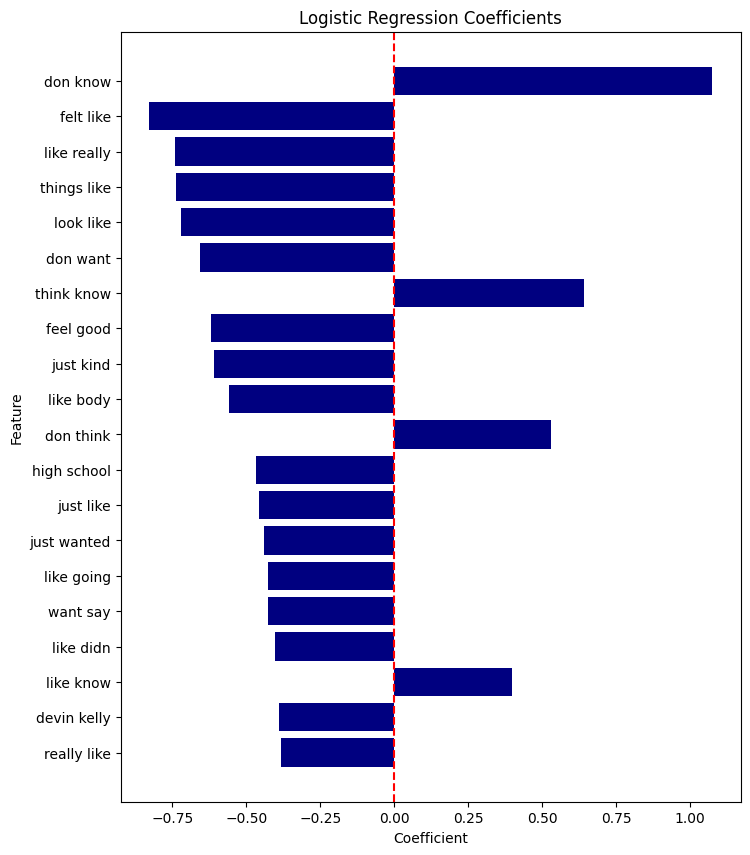

In [14]:
plot_coefs(
    lr,
    tfidf_vectorizer.get_feature_names_out(),
    top_n=20,
    x_size=8,
    y_size=10
)